# Chapter 7

## WITNESS model

In [1]:
import numpy as np
from scipy import optimize
np.set_printoptions(precision=2)

## WITNESS architecture

* recognition decisions are based on direct comparisons between the test items (people in the lineup vs contents of memory)
* the only relevant content is the face of the perpretrator

### 1. Stimuli

All stimuli are represented as random vectors made of $k$ features. 

$$ \textrm{stimulus} = (f_1,f_2,...,f_k) $$

Each features is drawn from a uniform distribution with mean zero and range (-5,.5).

$$ f \sim \mathcal{U}(-.5,+.5) $$

Note that one stimulus vector will represent the perpetrator, and others will represent the foils in the lineup.

For example,

In [2]:
# make a "person"

k = 10 # num features per stimulus vector

stimulus = np.random.uniform(-.5,.5,size=k)

print stimulus

[ 0.23  0.16  0.02  0.35  0.18  0.36  0.36  0.21  0.03 -0.24]


### 2. Encoding

Encoding into memory is assumed to be imperfect.

When a stimulus is encoded into memory, it gets transformed into a new feature vector. In the process, it loses quality. This is implemented in the model by only allowing some fraction $s$ of the features from true stimulus vector to be retained in the new memory vector.

For example, memories might be actual faces degraded by half, so then $ s = \frac{1}{2} $.

Here is an example where memories of faces degrade by half, and stimuli are made of 10 features:

In [8]:
s = .5
n_features = 10

# perceive a perpetrator
perp = np.random.uniform(-.5,.5, size=n_features)
print perp

## degrade the face to a memory representation

# create empty vector to hold vals
memory = np.zeros_like(perp)

# pick the features from encoding to keep
n_keep = int(s*n_features)
keep_features = np.random.choice(range(n_features), size=n_keep, replace=False)
print keep_features

# insert same values into memory
memory[keep_features] = perp[keep_features]

# replace remaining zeros with new values from uniform distrn
memory[np.where(memory==0)] = np.random.uniform(-.5,.5, size=n_features-n_keep)
print memory

[ 0.43 -0.22  0.29 -0.49  0.2   0.03  0.1  -0.1  -0.16 -0.37]
[1 8 9 0 6]
[ 0.43 -0.22 -0.43  0.35  0.09  0.5   0.1   0.47 -0.16 -0.37]


### 3. Handling complex similarity relationships between the perpetrator and the foils

In this simplified version of WITNESS, there is one parameter, $sim$, that represents the similarity between a perpetrator and a foil.

This is, again, a fraction of the total features that should be identical between the vectors representing perpetrator and any given foil.

Code would look very similar to the example above.

### 4. Retrieval ("doing" the lineup)

In a real lineup, you look at each face one-by-own, going down the line, and comparing the similarity of each face to the face you are holding in memory. To simulate this in WITNESS, we use the dot product.

A dot product, $d$, is a measure of similarity between two vectors.

The greater the dot product, the more similar two vectors are. In WITNESS, the recognition decision relies on evaluating dot products between the faces in the lineup and $\textbf{M}$, the memory of the perpetrator.

In [37]:
n_features = 10

perp = np.random.uniform(-.5,.5, size=n_features)

def create_foil(perp, s):
    # this is similar code from above, turned into a function
    # so to return a new foil with predefined similarity
    n_features = perp.size
    foil = np.zeros_like(perp)
    n_same = int(s*n_features)
    same_features = np.random.choice(range(n_features), size=n_same, replace=False)
    foil[same_features] = perp[same_features]
    foil[np.where(foil==0)] = np.random.uniform(-.5,.5, size=n_features-n_same)
    return foil

foil_a = create_foil(perp, s=0.3)
foil_b = create_foil(perp, s=0.8)

print perp
print foil_a
print foil_b

# cycle through the lineup and see who "looks" most similar to the perp
for face in [foil_a, foil_b, perp]:
    similarity = np.dot(perp, face)
    print similarity

[-0.49 -0.11  0.1   0.21  0.36 -0.43 -0.33 -0.21 -0.39 -0.14]
[-0.27 -0.08 -0.01  0.21 -0.13 -0.33 -0.33 -0.06 -0.39  0.15]
[-0.49 -0.11  0.1  -0.13  0.36 -0.43 -0.33 -0.21  0.22 -0.14]
0.529046953917
0.629654701899
0.941753544369


We just compared lineup faces to the _actual_ perpertrator, not the _memory_ of the perp. So obviously in the lineup you are using your memory, so let's do that.

I am going to cheat and use the create_foil function to make a memory vector of the perp, to avoid redoing that code. This works fine, as long as the $s$ parameter is specified appropriately.

In [49]:
perp = np.random.uniform(-.5,.5, size=n_features)

foil_a = create_foil(perp, s=0.2)
foil_b = create_foil(perp, s=0.5)

memory = create_foil(perp, s=0.9)

for face in [perp, foil_a, foil_b]:
    similarity = np.dot(memory, face)
    print similarity

1.26346287141
0.272612230545
0.548494083404


### 5. Different response types

There are 2 different response types from someone participating (as judge) in the lineup.

* identification ("it's him")
    * could be right or wrong
* rejection ("perp is not present")

**Now we have a simple decision criterion.**

When cycling through the faces, if the highest similarity measure is above a threshold, $c_{rec}$, the model chooses that person as the perp (ie, response is _identification_). Else, if no similarity measure passes $c_{rec}$, then response is a _rejection_.

# WITNESSSSSSSS


### Verbal overshadowing

When people complete a verbal report of the crime after viewing it, it surprisingly results in _fewer_ correct identifications of the perpetrator.

The purpose of using WITNESS here is to differentiate between different possible explanations.

1. **Memory** explanation - memory is hurt
2. **criterion** explanation - people are more reluctant to pick


### Forced-choice situation
* Criterion predicts that in a forced-choice situation, they should perform just as well as if they didn't do the verbal reporting. The memory explanation would results in lesser correct identifications in either case.


### Optional-choice situation
* If perp _is_ present, both expect poorer performance, but criterion case predicts there to be more _rejection_ errors, while memory case predicts more false _identifications_.
* If perp _is not_ present, criterion expects increase in accuracy, and memory again predicts worse performance.


### What are we doing?

Book focuses on two experiments from Clare and Lewandowsky (2004).

1. (exp1) optional-choice with perp present and not present
2. (exp2) forced-choice with perp always present


### We have to estimate 5 free parameters.

> $s = $ encoding strength (how much does perception degrade to memory)

>$sim = $ similarity (between perp and foils)

>$c_{rec}(C) = $ baseline criterion (to pick the perp)

>$c_{rec}(H) = $ holistic criterion ($c_{rec}(C)$ after holistic verbalization)

>$c_{rec}(F) = $ featural criterion ($c_{rec}(C)$ after featural verbalization)


## Functions we will be using to run the model

Before making the main WITNESS function, I'd rather make the small tedious ones first (the book does it reverse).

In [48]:
# getvec
def makeface(n_feats):
    '''return a vector representing humAn face'''
    return np.random.uniform(-.5,+.5, size=n_feats)
#     return np.random.rand(n_feats)

# getsimvec
def makesimface(face, s):
    '''return a face with proportion s similar features'''
    n_feats = face.size
    mask = np.random.uniform(size=n_feats) < s
    return face*mask + ~mask*makeface(n_feats)

def decision(match_vals, cRec):
    if np.max(match_vals) < cRec:
        response = 2 # reject
    else:
        j = np.argmax(match_vals)
        if j == 0: # suspect or perp is always first in lineup
            response = 0
        else:
            response = 1
    return response

Now we make the main WITNESS function. Then we have to make the script that does the actual simulation.

In [60]:
# first initiate an object to carry around constants
class Consts(object):
    seed = 21335
    lu_size = 6
    n_reps = 1000
    n_feats = 100
    n_cond = 9
    f_choice = [6,7,8]
    paLineup = [3,4,5]
    ptToCrit = [2,3,4,2,3,4]
    maxParms = [1,1,np.inf,np.inf,np.inf]
    
    
# the WITNESS function
def witness(params):
    
    # get individual parameters from the input
    s = params[0]
    sim = params[1]
    pa_sim = sim # similarity to others when perp absent
    pp_sim = sim # similarity to others when perp present
    ssp = sim # similarity of person replacing perp on perp absent lineups
   
    
    # zero vector to hold values
    predictions = np.zeros([Consts.n_cond, 3])
    
    # cycle through the peeps
    for i in range(Consts.n_reps):
        
        # perceive the perp
        perp = makeface(Consts.n_feats)
        # put him/her in memory using free parameter s
        mem = makesimface(face=perp, s=s)
        
        # get an innocent suspect
        niceguy = makesimface(face=perp, s=ssp)
        
        # create both types of lineup
        pa_lineup = np.empty([Consts.lu_size, Consts.n_feats])
        pa_lineup[0,:] = niceguy
        pp_lineup = np.empty([Consts.lu_size, Consts.n_feats])
        pp_lineup[0,:] = perp
        for row in range(1,Consts.lu_size):
            pa_lineup[row,:] = makesimface(face=perp, s=pa_sim)
            pp_lineup[row,:] = makesimface(face=perp, s=pp_sim)
            
        # inspect the lineups
        pa_matches = [ np.dot(mem,pa_lineup[person,:]) for person in range(Consts.lu_size) ]
        pp_matches = [ np.dot(mem,pp_lineup[person,:]) for person in range(Consts.lu_size) ]
        
        # witness responds across all different conditions
        for lineup_indx in range(Consts.n_cond):
            if np.isin(lineup_indx, Consts.f_choice):
                # if this is a forced-choice condition, must respond
                cRec = 0
            else:
                cRec = params[Consts.ptToCrit[lineup_indx]]
            
            # choose between perp present or perp absent
            if np.isin(lineup_indx, Consts.paLineup):
                useMatch = pa_matches
            else:
                useMatch = pp_matches
            
            # make a decision and save it
            resp = decision(useMatch, cRec)
            predictions[lineup_indx,resp] += 1
            
    return predictions / Consts.n_reps

Great that did nothing but establish the function.

**_BEFORE_** we do the whole parameter search thing, let's see what some of what we just did looks like. We made a function, `witness`, that is supposed to estimate a lineup situation. It makes a fake perp, a fake lineup, and makes a decision. It takes is input, _an array of parameters that is repeatedly passed from fminsearch_.

BUT, we can see what happens, just by giving it a single set of parameters manually.

I don't know what will work, so I'm going to take the parameters they start with.

In [61]:
start_params = [0.29, 0.35, 1.05, 2.10, 1.80]
print witness(start_params)

[[ 0.79  0.18  0.03]
 [ 0.59  0.08  0.33]
 [ 0.68  0.12  0.2 ]
 [ 0.14  0.77  0.09]
 [ 0.05  0.27  0.68]
 [ 0.09  0.42  0.5 ]
 [ 0.81  0.19  0.  ]
 [ 0.81  0.19  0.  ]
 [ 0.81  0.19  0.  ]]


Each row is one of nine conditions we ran through (see figure 7.2)

Each column is a type of _response_, which is hard to define here because each row represents a different set of conditions (even different experiment, as 1-6 rows are exp1 and 7-9 are exp2).

But we now have something that can produce estimates of the data, **so now we can find best parameters.**

## Setting up the estimator function

When we run the simulation, **all we really end up calling is wrapper4fmin**. However, there is stuff that we have to set-up _within_ the fmin thing.

So here we set those up.

In [62]:
def bof(params):
    '''this plays the important role of evaluating the 
    "performance" of a given parameter set (RMSD in this case)
    '''
    predictions = witness(params)
    sd = (predictions-data)**2
    rmsd = np.sqrt(sum(sum(sd))/data.size)
    return rmsd

# this wrapper is unnecessary as far as i can tell
def Wwrapper4fminbound(params, data, bounds):
    results = optimize.minimize(bof, params, bounds=bounds)
    return results

## Lastly, parameter estimation and the final predictions with those params.

In [64]:
# data is pulled from Clark & Lewandowsky (2004)

data = np.array([
    [.80, .13, .07], # pp control
    [.57, .06, .36], # pp holistic
    [.69, .12, .19], # pp featural
    [.05, .72, .23], # pa control
    [.20, .28, .52], # pa holistic
    [.00, .48, .52], # pa featural
    [.86, .14, .00], # exp2 control (exp2 is forced-choice)
    [.81, .19, .00], # exp 2 holistic
    [.84, .16, .00], # exp 2 featural
])

start_params = np.array([
    0.2942, # s
    0.3508, # sim
    1.0455, # cRec - control
    2.0930, # cRec - holistic
    1.8050, # cRec - featural
])

# bounds are expressed as (min, max) pairs for each parameter
bounds = [
    (0, Consts.maxParms[0]),
    (0, Consts.maxParms[1]),
    (0, Consts.maxParms[2]),
    (0, Consts.maxParms[3]),
    (0, Consts.maxParms[4]),
]


# results = Wwrapper4fminbound(start_params, data, bounds)
results = optimize.minimize(bof, start_params, bounds=bounds)

print results

      fun: 0.064531359014794482
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -48334.46, -379269.6 ,   29490.45,  148322.97, -117229.99])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 168
      nit: 2
   status: 0
  success: True
        x: array([ 0.29,  0.35,  1.05,  2.09,  1.81])


In [65]:
final_predictions = witness(results.x)

print final_predictions

[[ 0.8   0.17  0.03]
 [ 0.62  0.07  0.3 ]
 [ 0.7   0.1   0.19]
 [ 0.16  0.77  0.07]
 [ 0.05  0.28  0.68]
 [ 0.08  0.44  0.48]
 [ 0.81  0.19  0.  ]
 [ 0.81  0.19  0.  ]
 [ 0.81  0.19  0.  ]]


# Plotting

To recreate a subset of the book figures, we will plot the _true_ data underneath the _predicted_ data, to qualitatively assess how well the model performed--**given its final set of parameters**.

In [66]:
from pandas import DataFrame, MultiIndex
import matplotlib.pyplot as plt
import seaborn as sea
plt.ion

<function matplotlib.pyplot.ion>

In [67]:
df = DataFrame(data[:6,:],
    columns=['hit','false_id','miss'],
    index=MultiIndex.from_tuples([
        ('pp', 'control'),
        ('pp', 'holistic'),
        ('pp', 'featural'),
        ('pa', 'control'),
        ('pa', 'holistic'),
        ('pa', 'featural'),
    ])
)

df

hit  false_id  miss
pp control   0.80      0.13  0.07
   holistic  0.57      0.06  0.36
   featural  0.69      0.12  0.19
pa control   0.05      0.72  0.23
   holistic  0.20      0.28  0.52
   featural  0.00      0.48  0.52

In [68]:
df = df.reset_index().rename(columns={
    'level_0': 'perp',
    'level_1': 'verbreport',
})

df = df.melt(value_vars=['hit','false_id','miss'], id_vars=['perp','verbreport'],
       var_name='resp_type', value_name='resp_proportion')

df

,perp,verbreport,resp_type,resp_proportion
0,pp,control,hit,0.80
1,pp,holistic,hit,0.57
2,pp,featural,hit,0.69
3,pa,control,hit,0.05
4,pa,holistic,hit,0.20
5,pa,featural,hit,0.00
6,pp,control,false_id,0.13
7,pp,holistic,false_id,0.06
8,pp,featural,false_id,0.12
9,pa,control,false_id,0.72


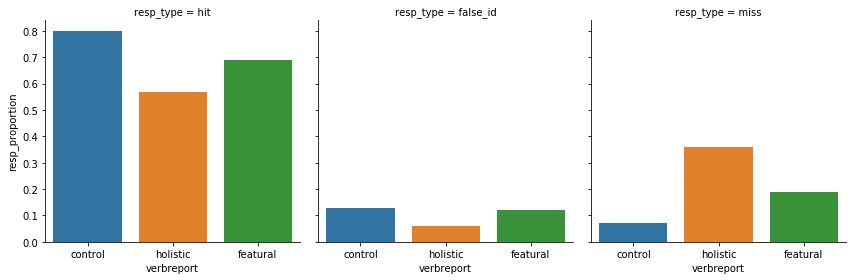

In [69]:
# Plot top row form figure 7.4
# Perpetrator present
ax = sea.factorplot(data=df[df['perp']=='pp'], x='verbreport', y='resp_proportion', col='resp_type', kind='bar')

In [72]:
# Plot the same thing but with predictions overlayed

# add predictions to dataframe
# by doing everything we did up there to the final_predictions array (instead of data)
pred_df = DataFrame(final_predictions[:6,:],
    columns=['hit','false_id','miss'],
    index=MultiIndex.from_tuples([
        ('pp', 'control'),
        ('pp', 'holistic'),
        ('pp', 'featural'),
        ('pa', 'control'),
        ('pa', 'holistic'),
        ('pa', 'featural'),
    ])
).reset_index(
    ).rename(columns={
        'level_0': 'perp',
        'level_1': 'verbreport',
    }).melt(
        value_vars=['hit','false_id','miss'],
        id_vars=['perp','verbreport'],
        var_name='resp_type', value_name='resp_proportion'
)

print 'predictions dataframe'
print pred_df

df['prediction'] = pred_df['resp_proportion']

print 'original dataframe appended'
print df

predictions dataframe
   perp verbreport resp_type  resp_proportion
0    pp    control       hit            0.799
1    pp   holistic       hit            0.623
2    pp   featural       hit            0.703
3    pa    control       hit            0.159
4    pa   holistic       hit            0.048
5    pa   featural       hit            0.079
6    pp    control  false_id            0.169
7    pp   holistic  false_id            0.074
8    pp   featural  false_id            0.105
9    pa    control  false_id            0.768
10   pa   holistic  false_id            0.277
11   pa   featural  false_id            0.442
12   pp    control      miss            0.032
13   pp   holistic      miss            0.303
14   pp   featural      miss            0.192
15   pa    control      miss            0.073
16   pa   holistic      miss            0.675
17   pa   featural      miss            0.479
original dataframe appended
   perp verbreport resp_type  resp_proportion  prediction
0    pp    control

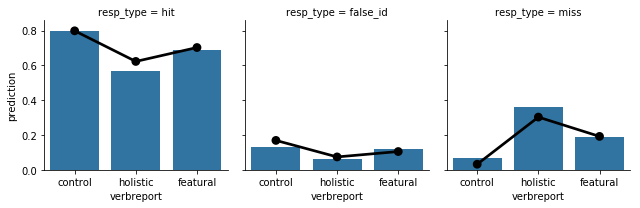

In [73]:
# plot the overlayed stuff

g = sea.FacetGrid(df[df['perp']=='pp'], col='resp_type')
order = ['control','holistic','featural']
g.map(sea.barplot, 'verbreport', 'resp_proportion', order=order, zorder=0)
g.map(sea.pointplot,'verbreport', 'prediction', color='black', order=order, zorder=10)